### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)


This Notebook depends on symbtools >=0.2.5

→ `pip install --upgrade symbtools`





In [2]:
%load_ext ipydex.displaytools
%matplotlib inline

import os
import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)
import scipy.integrate as sc_integrate
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL # Imports the solver IDA from Assimulo
from assimulo.problem import Implicit_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

The ipydex.displaytools extension is already loaded. To reload it, use:
  %reload_ext ipydex.displaytools


In [5]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 2
nq = 1
n = np + nq
pp = st.symb_vector("p1:{0}".format(np+1))
qq = st.symb_vector("q1:{0}".format(nq+1))


aa = st.symb_vector("a1:{0}".format(nq+1)) ##:T

ttheta = st.row_stack(pp, qq) ##:T
tthetad = st.time_deriv(ttheta, ttheta) ##:T
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
st.make_global(ttheta, tthetad, tthetadd)

---

---

---

---

In [6]:
params = sp.symbols('s1, s2, s3, m1, m2, m3, J1, J2, J3, l1, l2, l3, kappa1, kappa2, g')
st.make_global(params)

# ttau = sp.symbols('tau')
tau1, tau2 = ttau = st.symb_vector("tau1, tau2")


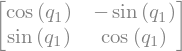

In [6]:
Rz(q1) # Rotationsmatirx

Specify the geometry (joints G and centers of masses S)

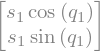

---

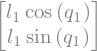

---

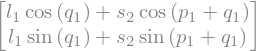

---

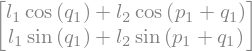

---

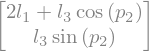

---

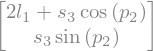

---

In [7]:
# uni vectors

ex = sp.Matrix([1, 0]) 
ey = sp.Matrix([0, 1]) 

# Basis 1 und 2
B1 = sp.Matrix([0, 0])
B2 = sp.Matrix([2*l1, 0])

# Coordinates two link manipulator
S1 = Rz(q1)*ex*s1 ##:

G1 = Rz(q1)*ex*l1 ##:

S2 = G1 + Rz(q1 + p1)*ex*s2 ##:

G2 = G1 + Rz(q1 + p1)*ex*l2 ##:


# one link manipulator
G2b = B2 + Rz(p2)*ex*l3 ##:

S3 = B2 + Rz(p2)*ex*s3 ##:


# Time derivative
Sd1, Sd2, Sd3 = st.col_split(st.time_deriv(st.col_stack(S1, S2, S3), ttheta))

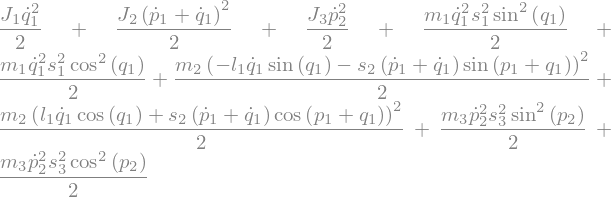

---

---

In [14]:
# kinetic energy

T_rot = (J1*qdot1**2 + J2*(qdot1 + pdot1)**2 + J3*(pdot2)**2)/2
T_trans = ( m1*Sd1.T*Sd1  +  m2*Sd2.T*Sd2 +  m3*Sd3.T*Sd3 )/2

T = T_rot + T_trans[0] ##:

# potential energy
V = m1*g*S1[1] + m2*g*S2[1] + m3*g*S3[1] ##:

In [15]:
# mu1, mu2 = mmu = st.symb_vector("mu1, mu2")

external_forces = [0 , 0, tau1]

mod = mt.generate_symbolic_model(T, V, ttheta, external_forces, constraints=[G2 - G2b])


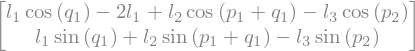

In [16]:
# condition that endeffectors of the two manipulators are at the same place (x and y)

mod.constraints

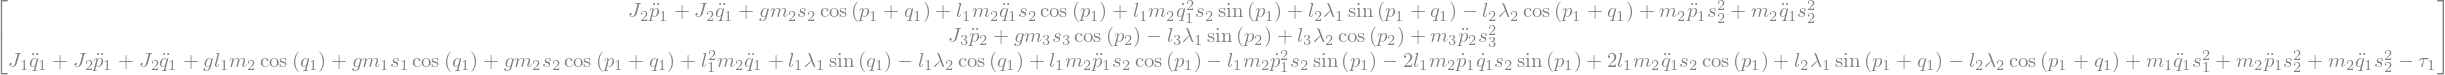

In [17]:
mod.eqns

### Creation of DAE System

In [12]:
parameter_values = list(dict(s1=1/2, s2=1/2, s3=1/2, m1=1, m2=1, m3=3, J1=1/12 , J2=1/12, J3=1/12, l1=1, l2=1.5, l3=1.5,  kappa1=3/2 , kappa2=14.715, g=9.81).items()) ##:

parameter_values := [('s1', 0.5),
 ('s2', 0.5),
 ('s3', 0.5),
 ('m1', 1),
 ('m2', 1),
 ('m3', 3),
 ('J1', 0.08333333333333333),
 ('J2', 0.08333333333333333),
 ('J3', 0.08333333333333333),
 ('l1', 1),
 ('l2', 1.5),
 ('l3', 1.5),
 ('kappa1', 1.5),
 ('kappa2', 14.715),
 ('g', 9.81)]

---

In [13]:
dae = mod.calc_dae_eq(parameter_values)
dae.generate_eqns_funcs()

In [14]:
dae.yy ##:T
dae.yyd ##:T

---

---

In [15]:
yy0, yyd0 = dae.calc_consistent_init_vals(p1=0.3) ##:

t0 = 0


# check if all values are almost zero (-> initial values fulfill the model)
assert npy.allclose(dae.model_func(t0, yy0, yyd0), 0)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 99
         Function evaluations: 195
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 67


(yy0, yyd0) := (array([0.3       , 1.59312994, 0.47128936, 0.        , 0.        , 0.        , 1.57409714, 2.45169093]),
 array([  0.        ,   0.        ,   0.        ,  22.50082349,   3.32555335, -12.36279   ,   0.        ,   0.        ]))

---

In [18]:
model = Implicit_Problem(dae.model_func, yy0, yyd0, t0)
model.name = 'fourbar linkage'

# indicate which components of y are differential (1) and which are purely algebraic (0)
# model.algvar = dae.diff_alg_vars ##:

sim = ODASSL(model)
# sim.suppress_alg = True #Necessary to set to True for >1 index problem

# values <= 30 produce lots of output
sim.verbosity = 0

In [19]:
tfinal = 10.0        # Specify the final time
ncp = 500            # Number of communication points (number of return points)

# takes about 48 seconds
tt_sol, yy_sol, yyd_sol = sim.simulate(tfinal, ncp) 

No initialization defined for the problem.
No finalization defined for the problem.
Final Run Statistics: fourbar linkage 

 Number of steps                           : 7032
 Number of function evaluations            : 17698
 Number of Jacobian evaluations            : 734
 Number of error test failures             : 232
 Number of nonlinear convergence failures  : 0

Solver options:

 Solver                  : ODASSL 
 Tolerances (absolute)   : 1e-06
 Tolerances (relative)   : 1e-06

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 20.658091253000748 seconds.


In [20]:
ttheta_sol = yy_sol[:, :mod.dae.ntt]
ttheta_d_sol = yy_sol[:, mod.dae.ntt:mod.dae.ntt*2]

Text(0.5, 1.0, 'angular velocities (with discontinuities ☹)')

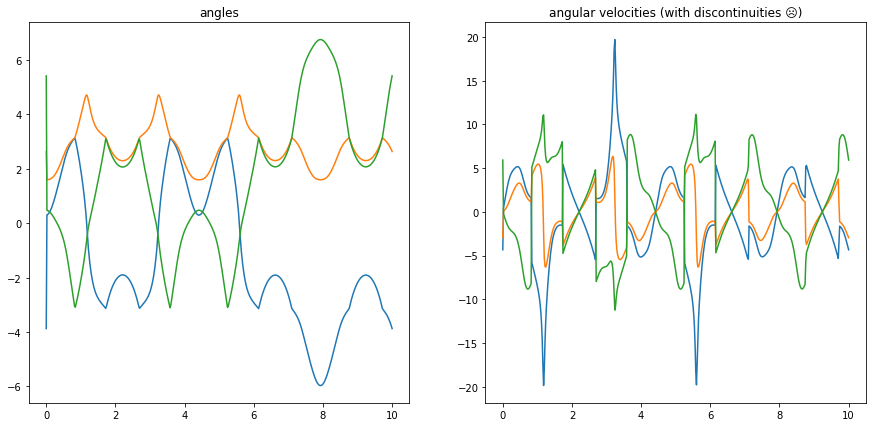

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7)); plt.sca(ax1)

ax1.plot(tt_sol, ttheta_sol)
ax1.set_title("angles")

ax2.plot(tt_sol, ttheta_d_sol)
ax2.set_title("angular velocities (with discontinuities ☹)")

####  Visualization and Animation

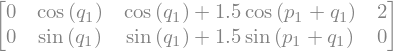

---

In [22]:
joint_pos_expr = st.col_stack(B1, G1, G2, B2).subs(parameter_values) ##:
joint_pos_func = st.expr_to_func(mod.tt, joint_pos_expr, keep_shape=True)

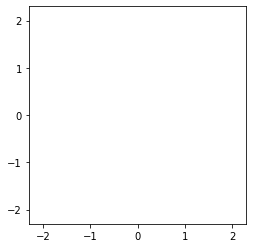

In [23]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = pl.figure() 
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2.3,2.3), ylim=(-2.3,2.3))
ax.set_aspect('equal')

line, = ax.plot([],[],'o-', lw=2)
time_template = 'time=%.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
dt = tt_sol[1] - tt_sol[0]


def init():
    line.set_data([],[])
    time_text.set_text('')
    return line, time_text

l1 =1.0

def animate(i):
    xx, yy = joint_pos_func(*ttheta_sol[i, :])
    
    line.set_data(xx,yy)
    time_text.set_text(time_template%(i*dt))
    return line, time_text


ani = animation.FuncAnimation(fig, animate, range(ttheta_sol.shape[0]), interval=tt_sol[-1]*3, blit=True, init_func=init)


# this animation is nice but results in a big notebook file which is unwanted for publication in the repo
# HTML(ani.to_jshtml())





*Preliminary Conclusion*

→ Behavior looks more or less realistic - up to the configurations where $p_1$ is an integer multiple of $\pi$ (joint is fully streched or fully bended). Probably there are singularities.

In [24]:
# this might need to be adapted on other systems

plt.rcParams["animation.codec"] = "libvpx-vp9"  # codec for webm
plt.rcParams['animation.ffmpeg_path'] = os.path.join(os.getenv("CONDA_PREFIX"), "bin", "ffmpeg")
writer = animation.FFMpegWriter(fps=30)
ani.save("fourbar_linkage_with_singularities.webm", writer=writer)

TypeError: expected str, bytes or os.PathLike object, not NoneType

In [25]:
%%HTML
<video width="320" height="240" controls>
  <source src="fourbar_linkage_with_singularities.webm" type="video/webm">
</video>